교통사고 심각도 예측

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 데이터 로드
data_path = '/Users/jeonghansol/Documents/US_Accidents_March23.csv'  # 데이터 파일 경로
df = pd.read_csv(data_path)

df = df.sample(frac=0.5, random_state=42)

In [3]:
features = [
    'Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
    'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
    'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
    'Start_Time'
]
df = df[features].dropna()

# 날짜 시간 관련 특성 추가
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df.dropna(subset=['Start_Time'], inplace=True)
df['Weekday'] = df['Start_Time'].dt.weekday
df['Hour'] = df['Start_Time'].dt.hour

# 원-핫 인코딩 대상 범주형 변수
categorical_features = [
    'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
    'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
]
df = pd.get_dummies(df, columns=categorical_features)

In [4]:
# 출력 레이블 설정
df['Severity_Level'] = df['Severity'].apply(lambda x: min(max(int(x), 1), 4))

# 특성과 레이블 분리
X = df.drop(columns=['Severity', 'Severity_Level', 'Start_Time'])
y = df['Severity_Level']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 모델 생성 및 학습
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 초기 모델 평가
initial_accuracy = accuracy_score(y_test, y_pred)
print("Initial Model Accuracy:", initial_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Initial Model Accuracy: 0.7497471556345271

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.20      0.19      6141
           2       0.85      0.86      0.85    386337
           3       0.27      0.26      0.27     63952
           4       0.15      0.15      0.15     11249

    accuracy                           0.75    467679
   macro avg       0.36      0.37      0.36    467679
weighted avg       0.75      0.75      0.75    467679



In [5]:
# 특징 중요도 추출
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도 순으로 정렬
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 상위 20개 특징 확인
print("Top 20 Features:")
print(feature_importance_df.head(20))

Top 20 Features:
                             Feature  Importance
2                       Pressure(in)    0.180732
1                        Humidity(%)    0.137825
0                     Temperature(F)    0.133483
4                    Wind_Speed(mph)    0.085266
7                               Hour    0.078919
6                            Weekday    0.069789
3                     Visibility(mi)    0.029481
5                  Precipitation(in)    0.015215
159                    Crossing_True    0.013137
19                  Wind_Direction_S    0.011454
27                  Wind_Direction_W    0.010231
22                Wind_Direction_SSW    0.009638
23                 Wind_Direction_SW    0.009256
13                  Wind_Direction_N    0.009191
29                Wind_Direction_WSW    0.008744
28                Wind_Direction_WNW    0.008668
21                Wind_Direction_SSE    0.008662
9                   Wind_Direction_E    0.008482
100  Weather_Condition_Mostly Cloudy    0.008078
16 

In [6]:
# 중요도 임계값 설정
importance_threshold = 0.01

# 중요도가 낮은 특징 식별
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature'].tolist()

# 중요도가 낮은 특징 제거
X_reduced = df.drop(columns=['Severity', 'Severity_Level', 'Start_Time'] + low_importance_features)


In [7]:
# 데이터 스케일링
X_reduced_scaled = scaler.fit_transform(X_reduced)

# 데이터 분할
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced_scaled, y, test_size=0.2, random_state=42
)

# 모델 생성 및 학습
model_reduced = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_reduced.fit(X_train_reduced, y_train_reduced)

# 예측
y_pred_reduced = model_reduced.predict(X_test_reduced)

# 재학습된 모델 평가
reduced_accuracy = accuracy_score(y_test_reduced, y_pred_reduced)
print("Reduced Model Accuracy:", reduced_accuracy)
print("\nClassification Report:\n", classification_report(y_test_reduced, y_pred_reduced))


Reduced Model Accuracy: 0.7482247438948509

Classification Report:
               precision    recall  f1-score   support

           1       0.19      0.23      0.20      6141
           2       0.85      0.86      0.85    386337
           3       0.27      0.25      0.26     63952
           4       0.16      0.16      0.16     11249

    accuracy                           0.75    467679
   macro avg       0.37      0.37      0.37    467679
weighted avg       0.75      0.75      0.75    467679



In [8]:
print("Initial Model Accuracy:", initial_accuracy)
print("Reduced Model Accuracy:", reduced_accuracy)
print(f"Number of Features Before: {X.shape[1]}")
print(f"Number of Features After: {X_reduced.shape[1]}")


Initial Model Accuracy: 0.7497471556345271
Reduced Model Accuracy: 0.7482247438948509
Number of Features Before: 187
Number of Features After: 11


In [9]:
def evaluate_model_with_threshold(threshold):
    # 중요도가 낮은 특징 식별
    low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()
    
    # 특징 제거
    X_temp = df.drop(columns=['Severity', 'Severity_Level', 'Start_Time'] + low_importance_features)
    X_temp_scaled = scaler.fit_transform(X_temp)
    
    # 데이터 분할
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X_temp_scaled, y, test_size=0.2, random_state=42
    )
    
    # 모델 학습 및 평가
    model_temp = DecisionTreeClassifier(criterion='entropy', random_state=42)
    model_temp.fit(X_train_temp, y_train_temp)
    y_pred_temp = model_temp.predict(X_test_temp)
    accuracy = accuracy_score(y_test_temp, y_pred_temp)
    
    print(f"Threshold: {threshold}, Accuracy: {accuracy}, Number of Features: {X_temp.shape[1]}")
    return accuracy

# 다양한 임계값에 대해 평가
thresholds = [0.001, 0.005, 0.01]
for thresh in thresholds:
    evaluate_model_with_threshold(thresh)


Threshold: 0.001, Accuracy: 0.7487699896724035, Number of Features: 51
Threshold: 0.005, Accuracy: 0.748421460018517, Number of Features: 34
Threshold: 0.01, Accuracy: 0.7482247438948509, Number of Features: 11


In [13]:
features = ['Severity', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
df = df[features].dropna()

# 출력 레이블 설정
df['Severity_Level'] = df['Severity'].apply(lambda x: min(max(x, 1), 4))

# 데이터 분리
X = df[['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']] 
y = df['Severity_Level']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습 
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8206419360287719

Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.01      0.02      6141
           2       0.83      0.98      0.90    386337
           3       0.38      0.05      0.10     63952
           4       0.19      0.01      0.03     11249

    accuracy                           0.82    467679
   macro avg       0.39      0.27      0.26    467679
weighted avg       0.74      0.82      0.76    467679



In [17]:
# 분류 결과를 DataFrame으로 구성
results = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),  # 실제 값
    'Predicted': y_pred                      # 예측 값
})

# 분류된 결과 출력
print("Classification Results:")
print(results.head())  # 상위 몇 개 결과만 출력

Classification Results:
   Actual  Predicted
0       2          2
1       4          2
2       2          2
3       2          2
4       2          2


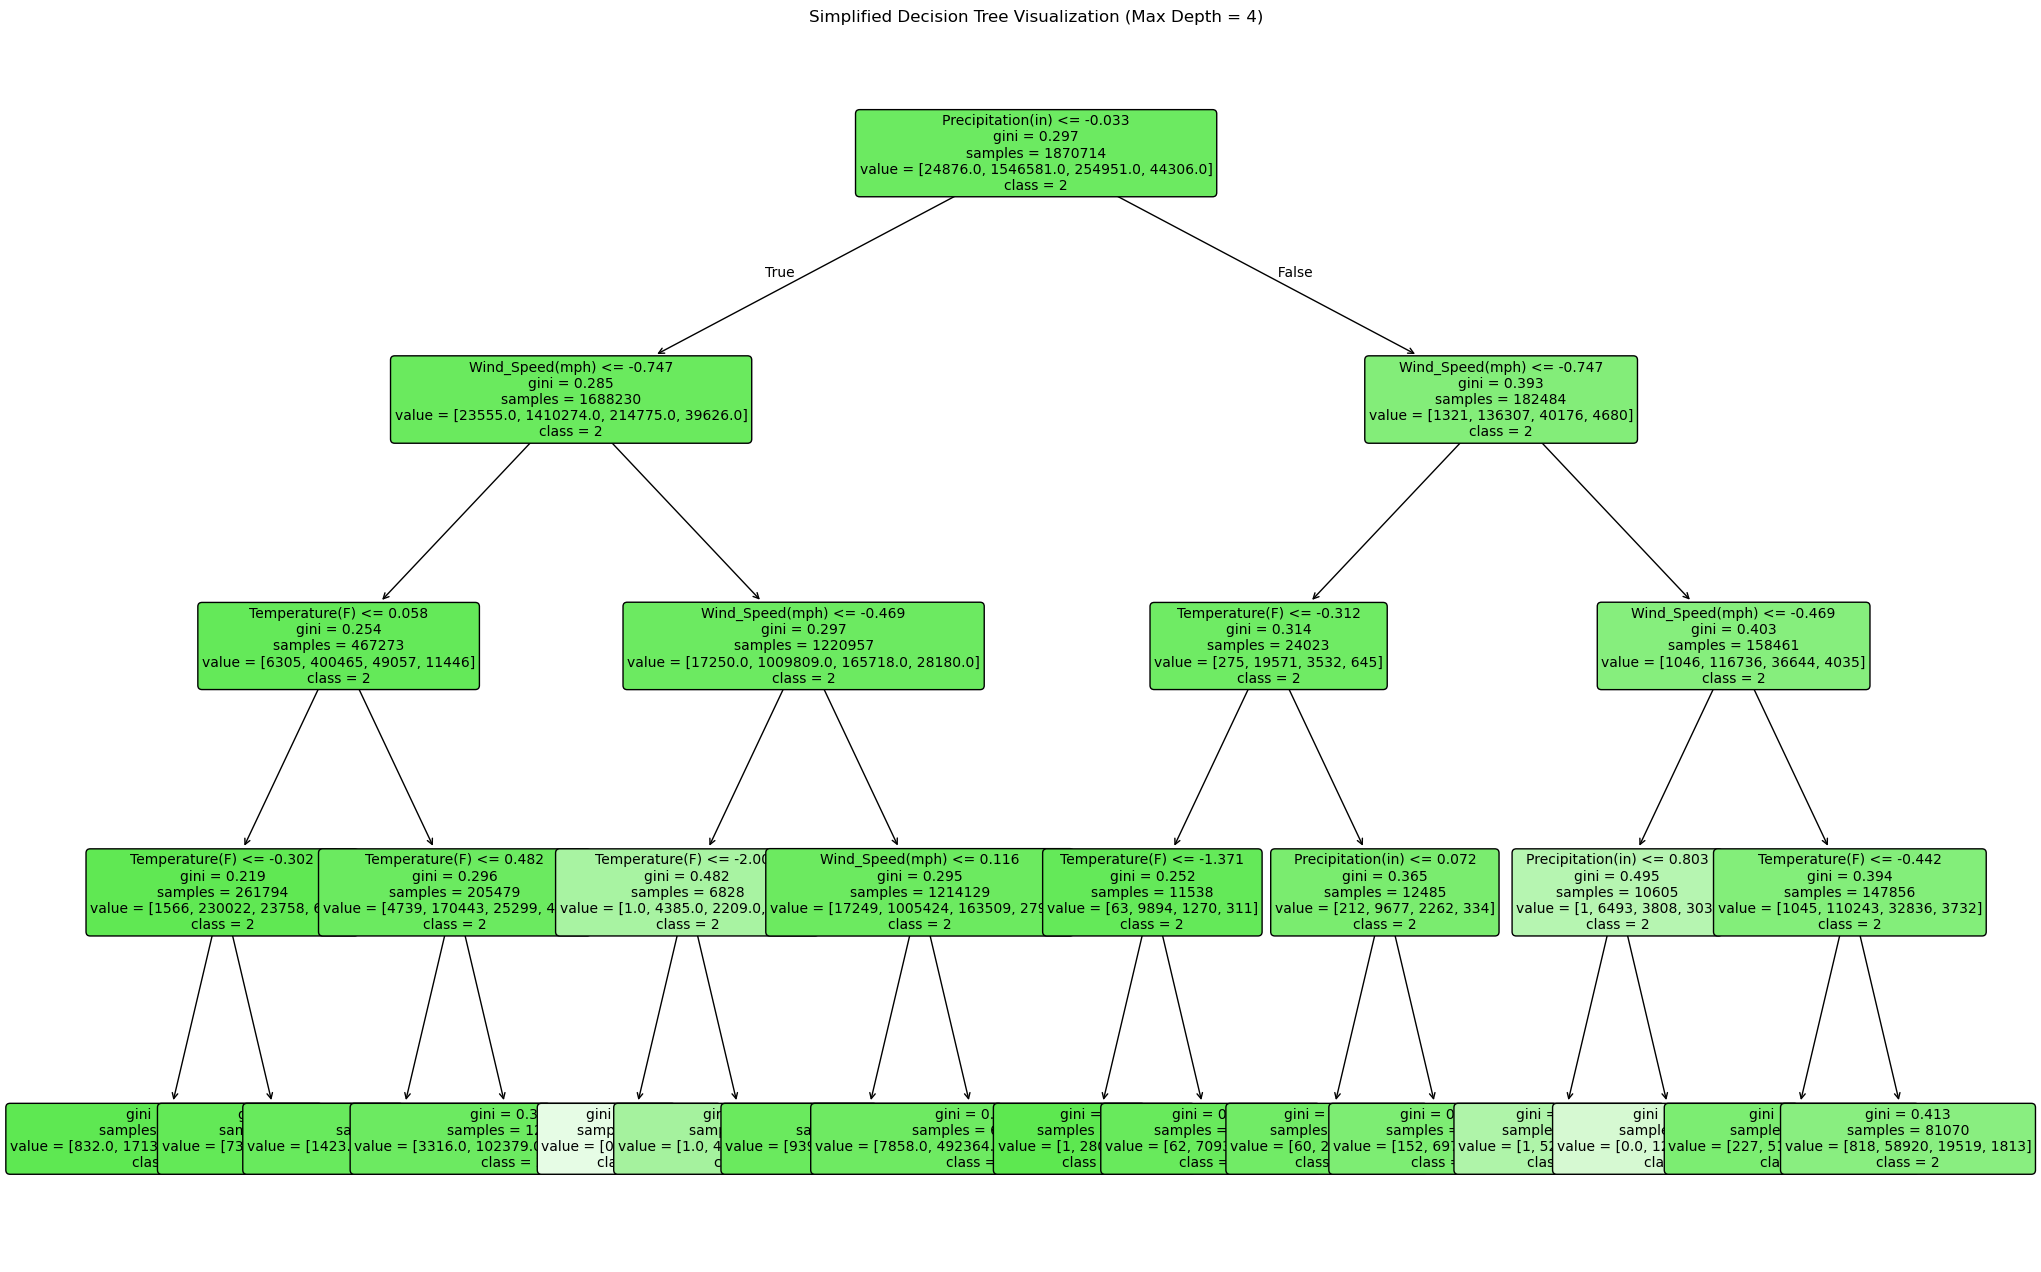

In [24]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 의사결정트리 모델 생성 시 max_depth로 깊이 제한
model = DecisionTreeClassifier(random_state=42, max_depth=4)  # 최대 깊이를 3으로 제한
model.fit(X_train, y_train)

# 시각화
plt.figure(figsize=(24, 16))
plot_tree(model, 
          feature_names=['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)','Pressure(in)','Humidity(%)'],
          class_names=['1', '2', '3', '4'], 
          filled=True, 
          rounded=True,
         fontsize=10)
plt.title("Simplified Decision Tree Visualization (Max Depth = 4)")
plt.show()

https://chatgpt.com/share/674ebe4c-5dac-8007-8d60-fecb413e66c3